<a href="https://colab.research.google.com/github/RusiruWijethilake/DepFlow/blob/main/depflow_nlp_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install emoji
!pip install fasttext

import json
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import tarfile

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

In [ ]:
vocab_size = 2957
embedding_dim = 300
max_length = 20
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 800
num_epochs = 15

In [ ]:
sentences = []
labels = []

# Load the dataset
url = "https://raw.githubusercontent.com/RusiruWijethilake/DepFlow/main/new_dataset.csv"
df = pd.read_csv(url)

labels = df['class']

for sent in df['text']:
  sentences.append(sent)

In [ ]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [1]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
vocab_size = len(word_index)
print(len(word_index))

pyperclip.copy(list_string)

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

NameError: ignored

In [ ]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.si.300.bin.gz
!gzip -d cc.si.300.bin.gz

--2023-04-19 18:07:51--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.si.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.249.141.9, 13.249.141.108, 13.249.141.13, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.249.141.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3181346570 (3.0G) [application/octet-stream]
Saving to: ‘cc.si.300.bin.gz.1’

cc.si.300.bin.gz.1  100%[===================>]   2.96G  98.3MB/s    in 19s     

2023-04-19 18:08:11 (159 MB/s) - ‘cc.si.300.bin.gz.1’ saved [3181346570/3181346570]

gzip: cc.si.300.bin already exists; do you wish to overwrite (y or n)? n
	not overwritten


In [ ]:
import fasttext
import fasttext.util

ft = fasttext.load_model("cc.si.300.bin")
ft.get_dimension()

# Mapping FastText word vectors with word in the dataset 
embedding_dim = ft.get_dimension()
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = ft.get_word_vector(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 20, 300)           1106100   
                                                                 
 lstm_5 (LSTM)               (None, 128)               219648    
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,325,877
Trainable params: 219,777
Non-trainable params: 1,106,100
_________________________________________________________________


In [ ]:
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/15
25/25 - 11s - loss: 0.6632 - accuracy: 0.6187 - val_loss: 0.5879 - val_accuracy: 0.7171 - 11s/epoch - 447ms/step
Epoch 2/15
25/25 - 0s - loss: 0.5701 - accuracy: 0.7188 - val_loss: 0.5053 - val_accuracy: 0.7220 - 136ms/epoch - 5ms/step
Epoch 3/15
25/25 - 0s - loss: 0.4998 - accuracy: 0.7538 - val_loss: 0.5136 - val_accuracy: 0.7268 - 176ms/epoch - 7ms/step
Epoch 4/15
25/25 - 0s - loss: 0.4518 - accuracy: 0.7875 - val_loss: 0.5304 - val_accuracy: 0.7268 - 159ms/epoch - 6ms/step
Epoch 5/15
25/25 - 0s - loss: 0.4316 - accuracy: 0.7975 - val_loss: 0.6548 - val_accuracy: 0.7317 - 151ms/epoch - 6ms/step
Epoch 6/15
25/25 - 0s - loss: 0.4075 - accuracy: 0.8112 - val_loss: 0.5354 - val_accuracy: 0.7122 - 153ms/epoch - 6ms/step
Epoch 7/15
25/25 - 0s - loss: 0.4071 - accuracy: 0.8200 - val_loss: 0.8643 - val_accuracy: 0.7317 - 201ms/epoch - 8ms/step
Epoch 8/15
25/25 - 0s - loss: 0.3716 - accuracy: 0.8363 - val_loss: 0.6088 - val_accuracy: 0.7317 - 142ms/epoch - 6ms/step
Epoch 9/15
25/2

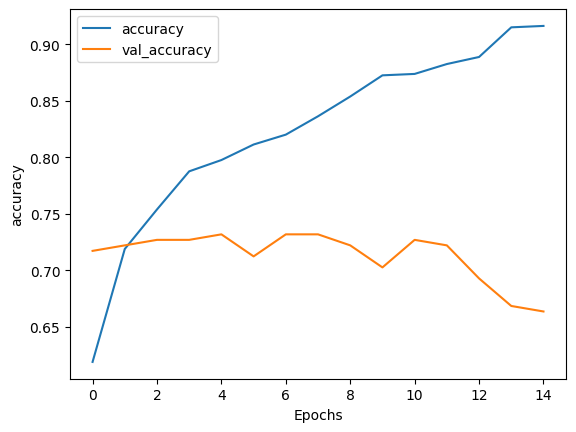

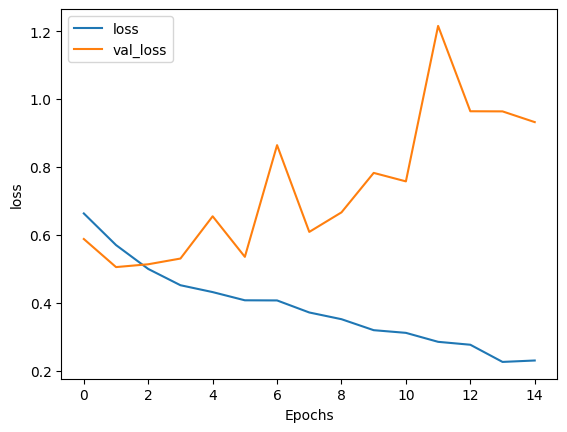

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# Model Evaluation
eval_sequences = tokenizer.texts_to_sequences(testing_sentences)
eval_padded = pad_sequences(eval_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
pred = model.predict(eval_padded)
predicted_labels = []
for x in pred:
  predicted_labels.append(int(x.round().item()))

predicted_labels = tf.convert_to_tensor(predicted_labels)
print(classification_report(testing_labels, predicted_labels))

7/7 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.74      0.82      0.78       148
           1       0.35      0.25      0.29        57

    accuracy                           0.66       205
   macro avg       0.54      0.53      0.53       205
weighted avg       0.63      0.66      0.64       205



In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

නැති බැරි කම් අග හිග කම් මැද ජීවත් වෙනවට වඩා හොදයි මියදුනා නම් දෙයියනේ ? ? ? ? ? ?
හැමදේම අත හැර ගියා නම් හරි වගේ 
1


In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(3687, 300)


In [ ]:
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

In [ ]:
!mkdir -p saved_model
model.save('saved_model/depflow_model_trained')
model.save('depflow_trained_model.h5')

In [ ]:
sentence = [simplifySinhala("මට ඇති මේ දුක දරන් හිටියා."), simplifySinhala("මට සතුටුයි හොදටම")]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 [==============================] - 0s 25ms/step
[[0.9117801]
 [0.1867858]]


In [ ]:
def check_depressive(post: str):
  sentence = [post]
  sequences = tokenizer.texts_to_sequences(sentence)
  padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
  post_prediction = model.predict(padded)
  label = post_prediction.round().item()
  if label == 1 :
    print(post, " : is a depressive post - ", post_prediction)
  else:
    print(post, " : is not a depressive post - ", post_prediction)

check_depressive("මට ඇති මේ දුක දරන් හිටියා.")
check_depressive("මම මැරිලම යන්නම්")
check_depressive("මම මරිලා ගියාම හැමොටම හොදයි.")
check_depressive("දුක කියන්නෙ හෙට වැඩට යන්න තිබීමයි")
check_depressive("අපි හෙට උදේට මොනවද කන්නේ?")
check_depressive('ඇයි මට මෙච්චර දුකක් දෙන්නේ දෙවියනේ')
check_depressive('ඔයාටනම් ඉතින් හිනා')
check_depressive('මම හිතන්නේ මට තනිකම දැනෙනවා වැඩී')
check_depressive('මට හොදටම depression')
check_depressive('I feel like I want to cry')
check_depressive('මම මේ දවස් ටිකේම දුක දරාගන්න බැරුව හොදටම ඇඩුවා')

1/1 [==============================] - 0s 34ms/step
1.0
මට ඇති මේ දුක දරන් හිටියා.  : is a depressive post -  [[0.7680453]]
1/1 [==============================] - 0s 39ms/step
0.0
මම මැරිලම යන්නම්  : is not a depressive post -  [[0.20818467]]
1/1 [==============================] - 0s 30ms/step
1.0
මම මරිලා ගියාම හැමොටම හොදයි.  : is a depressive post -  [[0.8051447]]
1/1 [==============================] - 0s 29ms/step
0.0
දුක කියන්නෙ හෙට වැඩට යන්න තිබීමයි  : is not a depressive post -  [[0.15808511]]
1/1 [==============================] - 0s 32ms/step
0.0
අපි හෙට උදේට මොනවද කන්නේ?  : is not a depressive post -  [[8.353172e-05]]
1/1 [==============================] - 0s 40ms/step
1.0
ඇයි මට මෙච්චර දුකක් දෙන්නේ දෙවියනේ  : is a depressive post -  [[0.83801836]]
1/1 [==============================] - 0s 30ms/step
0.0
ඔයාටනම් ඉතින් හිනා  : is not a depressive post -  [[0.0642387]]
1/1 [==============================] - 0s 34ms/step
1.0
මම හිතන්නේ මට තනිකම දැනෙනවා වැඩී  : is a depressive post